In [1]:
#importing important libs
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "/kaggle/input/id-address-ocr"

In [3]:
dir_list = os.listdir(path)
print("Total files found:", len(dir_list))

Total files found: 39984


In [4]:
dir_list = list(set([f.split(".")[0] for f in dir_list]))
print("Unique samples:", len(dir_list))

Unique samples: 19992


In [5]:
X = []
y = []
for i in dir_list:
    image_dir = os.path.join(path, i + ".jpg")
    txt_dir = os.path.join(path, i + ".txt")
    if os.path.exists(image_dir) and os.path.exists(txt_dir):
        X.append(cv2.cvtColor(cv2.imread(image_dir), cv2.COLOR_BGR2RGB))
        with open(txt_dir, 'r') as f:
            y.append(f.read())

print(f"Loaded {len(X)} images and {len(y)} labels.")


Loaded 19992 images and 19992 labels.


In [6]:
#Function to display Images
import matplotlib.pyplot as plt
import numpy as np
import math

def display_images(images, titles=None):
    """
    Display a list of images.

    Parameters:
    images (list): List of images as NumPy arrays.
    titles (list): List of titles for the images (optional).
    """
    num_images = len(images)
    if titles and len(titles) != num_images:
        raise ValueError("The length of titles must match the number of images.")

    cols = 5
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 2 * rows))
    axes = axes.flatten()

    for ax in axes[num_images:]:
        ax.axis('off')

    for i, img in enumerate(images):
        ax = axes[i]
        ax.imshow(img)
        if titles:
            ax.set_title(titles[i], fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

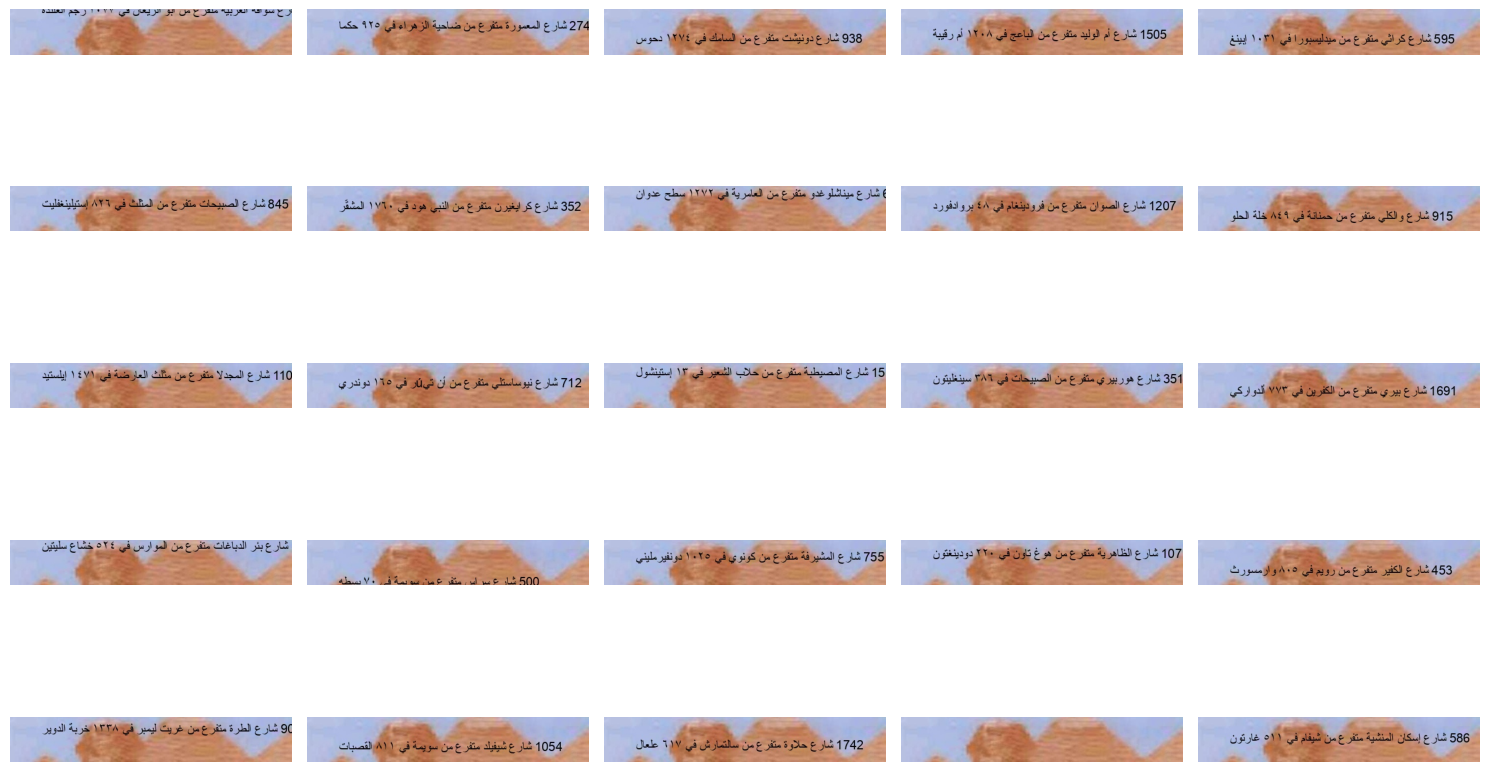

In [7]:
display_images(X[:25])

In [8]:
#converting list to numpy array and see the shape
X = np.array(X)
X.shape

(19992, 80, 500, 3)

In [9]:
#convert txt data list to np.array
y = np.array(y)
y.shape

(19992,)

In [10]:
#flattten all txt to Extract chars list
flatten_label = " ".join(y)
len(flatten_label)

1034693

In [11]:
print(flatten_label[:100])

658 شارع سواقة الغربية متفرع من أبو الزيغان في ١٠٧٧ رجم العلندة 274 شارع المعمورة متفرع من ضاحية الز


In [12]:
#Get char list
char_list = [*set(flatten_label)]
len(char_list)

64

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

2025-08-31 10:46:21.222346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756637181.399844      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756637181.451272      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing

In [14]:
X = np.mean(X, axis=-1, keepdims=True)  # average over channels → grayscale
X = X / 255.0  # normalize to [0,1]
print("New X shape:", X.shape)

New X shape: (19992, 80, 500, 1)


# Data Preperation

In [15]:
char_list[:] = [ch for ch in char_list if ch not in ['b','c','i','r','a','A','ú','ّ']]
len(char_list)

56

In [16]:
chars = sorted(list(set("".join(char_list))))
char_to_num = {c:i for i,c in enumerate(chars)}  # Start from 0
num_to_char = {i:c for i,c in enumerate(chars)}

# Number of classes = number of characters + 1 (for blank token)
num_classes = len(chars) + 1

# Blank token is at the highest index
blank_token_idx = len(chars)  # This should be num_classes - 1

print(f"Number of characters: {len(chars)}")
print(f"Number of classes: {num_classes}")
print(f"Blank token index: {blank_token_idx}")
print(f"Valid character indices: 0 to {len(chars)-1}")

Number of characters: 56
Number of classes: 57
Blank token index: 56
Valid character indices: 0 to 55


In [17]:
def encode_labels(labels):
    encoded = []
    for label in labels:
        enc = [char_to_num[c] for c in label if c in char_to_num]  # indices 0 to len(chars)-1
        encoded.append(enc)
    return encoded

y_encoded = encode_labels(y)
print("Org:",y[1])
print("Encoded:",y_encoded[1])

Org: 274 شارع المعمورة متفرع من ضاحية الزهراء في ٩٢٥ حكما
Encoded: [3, 8, 5, 0, 29, 16, 26, 34, 0, 16, 39, 40, 34, 40, 43, 26, 18, 0, 40, 19, 36, 26, 34, 0, 40, 41, 0, 31, 16, 22, 45, 18, 0, 16, 39, 27, 42, 26, 16, 11, 0, 36, 45, 0, 55, 48, 51, 0, 22, 38, 40, 16]


# CRNN + CTC

In [18]:
labels = layers.Input(name="labels", shape=(None,), dtype="int32")
input_length = layers.Input(name="input_length", shape=(1,), dtype="int32")
label_length = layers.Input(name="label_length", shape=(1,), dtype="int32")

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(tf.reduce_mean(loss))   # ✅ loss gets registered automatically
        return y_pred

In [20]:
inputs = layers.Input(shape=X.shape[1:], name="image")

x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,1))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512, (3,3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,1))(x)
x = layers.Dropout(0.3)(x)

# --- Collapse Height Dimension ---
new_shape = (x.shape[2], x.shape[1]*x.shape[3])
x = layers.Reshape(target_shape=new_shape)(x)

# --- RNN ---
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)

# --- Output ---
num_classes = len(chars) + 1
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

I0000 00:00:1756637216.595083      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [21]:
ctc_output = CTCLayer()(labels, outputs, input_length, label_length)
training_model = Model(
    inputs=[inputs, labels, input_length, label_length],
    outputs=ctc_output
)
training_model.compile(optimizer="adam", loss=None)
training_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 80, 500,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 500,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 250,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 250,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 20, 125,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 20, 125,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 125,   │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 10, 125,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 125,   │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 125,   │  1,180,160 │ dropout[0][0]     │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 125,   │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 5, 125,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 125,    │          0 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 125, 2560) │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 125, 512)  │  5,769,216 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 125, 512)  │  1,574,912 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labels (InputLayer) │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,926,265 (34.05 MB)

 Trainable params: 8,924,729 (34.05 MB)

 Non-trainable params: 1,536 (6.00 KB)

# Training

In [22]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Ensure float32 for images
X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)

# --- CTC setup ---
# Calculate time steps after CNN+Pooling
# Your pooling layers: (2,2),(2,2),(2,1),(2,1)
# Width: 500 -> 500 / 2 / 2 / 1 / 1 = 125
time_steps = 125

input_length_train = np.full((len(X_train), 1), 125, dtype=np.int32)
input_length_test  = np.full((len(X_test), 1), 125, dtype=np.int32)

label_length_train = np.array([len(lbl) for lbl in y_train], dtype=np.int32).reshape(-1,1)
label_length_test  = np.array([len(lbl) for lbl in y_test], dtype=np.int32).reshape(-1,1)

# Pad labels to max length in dataset
max_label_len = max(label_length_train.max(), label_length_test.max())
padded_y_train = tf.keras.preprocessing.sequence.pad_sequences(
    y_train, maxlen=max_label_len, padding="post", value=0, dtype="int32"
)
padded_y_test = tf.keras.preprocessing.sequence.pad_sequences(
    y_test,  maxlen=max_label_len, padding="post", value=0, dtype="int32"
)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,           # Stop after 8 epochs without improvement
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Reduce LR by half
        patience=4,           # Wait 4 epochs
        min_lr=1e-6
    )
]

history = training_model.fit(
    x=[X_train, padded_y_train, input_length_train, label_length_train],
    y=np.zeros(len(X_train)),
    batch_size=32,
    epochs=75,
    validation_data=(
        [X_test, padded_y_test, input_length_test, label_length_test],
        np.zeros(len(X_test))
    ),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/75


E0000 00:00:1756637235.524613      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1756637235.999106      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


500/500 ━━━━━━━━━━━━━━━━━━━━ 119s 212ms/step - loss: 114.7608 - val_loss: 140.9205 - learning_rate: 0.0010
Epoch 2/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 103s 205ms/step - loss: 85.4395 - val_loss: 177.3344 - learning_rate: 0.0010
Epoch 3/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 103s 205ms/step - loss: 82.9734 - val_loss: 192.7811 - learning_rate: 0.0010
Epoch 4/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 102s 204ms/step - loss: 79.9003 - val_loss: 135.1053 - learning_rate: 0.0010
Epoch 5/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 102s 203ms/step - loss: 77.0690 - val_loss: 91.5440 - learning_rate: 0.0010
Epoch 6/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 202ms/step - loss: 73.6860 - val_loss: 83.4616 - learning_rate: 0.0010
Epoch 7/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 202ms/step - loss: 71.9315 - val_loss: 104.9781 - learning_rate: 0.0010
Epoch 8/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 202ms/step - loss: 69.4294 - val_loss: 70.7946 - learning_rate: 0.0010
Epoch 9/75
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 201ms/step - loss: 66.8638 - val

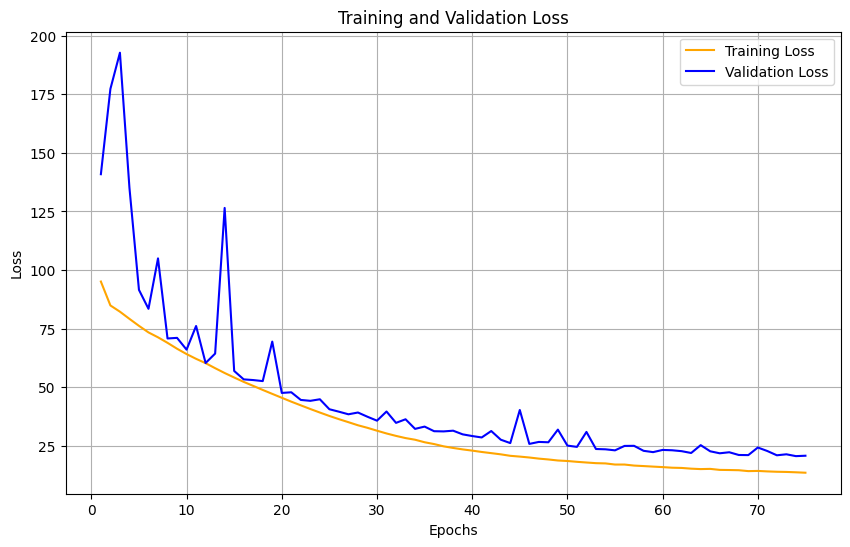

In [27]:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Get the number of epochs
    epochs = range(1, len(loss) + 1)
    
    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, color='orange', label='Training Loss')
    plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
def decode_predictions(preds, input_lengths, num_to_char, blank_index):
    """Properly decode CTC predictions"""
    decoded, _ = tf.keras.backend.ctc_decode(
        preds, 
        input_length=input_lengths,
        greedy=True
    )
    
    decoded = decoded[0].numpy()
    results = []
    
    for i in range(len(preds)):
        # Get valid indices (remove padding)
        sequence = decoded[i]
        valid_indices = sequence[sequence != -1]
        
        # CTC decoding: remove blanks and consecutive duplicates
        final_chars = []
        previous = blank_index
        for idx in valid_indices:
            if idx != blank_index and idx != previous:
                final_chars.append(idx)
            previous = idx
        
        # Convert to text
        text = "".join([num_to_char.get(ch, "") for ch in final_chars])
        results.append(text)
    
    return results

# Usage
preds = model.predict(X[:5])
input_lengths = np.ones(len(preds)) * 125  # Your calculated time steps
decoded_texts = decode_predictions(preds, input_lengths, num_to_char, blank_token_idx)

for i in range(5):
    print("Pred:", decoded_texts[i], " True:", y[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
Pred: 41 شارع سواقة الغربية متفرع من أسر الغريحان في ١٠٢ رجم العلندة  True: 658 شارع سواقة الغربية متفرع من أبو الزيغان في ١٠٧٧ رجم العلندة
Pred: 21 شارع المعمورة متفرع من ضاحية الهراء في ٨٧٤ جكما  True: 274 شارع المعمورة متفرع من ضاحية الزهراء في ٩٢٥ حكما
Pred: 947 شارع دونيشت متفرع من السامك في ١٢٧٤ دحوس  True: 938 شارع دونيشت متفرع من السامك في ١٢٧٤ دحوس
Pred: 1561 شارع أم الوليد متفرع من البابج في ١٢٩٦ أم رقيبة  True: 1505 شارع أم الوليد متفرع من الباعج في ١٢٠٨ أم رقيبة
Pred: 519 شارع كراثي متفرع من ميدليسبورا في ١٠٣١ إبينغ  True: 595 شارع كراثي متفرع من ميدليسبورا في ١٠٣١ إبينغ


# Save as onnx

In [32]:
# !pip install onnx -q
# !pip install tf2onnx -q

/bin/bash: line 1: conda: command not found


In [29]:
# Your original model (without CTC)
inference_model = Model(inputs=inputs, outputs=outputs)

# Load weights from trained model
inference_model.set_weights(training_model.get_weights())

# Test it works
sample_pred = inference_model.predict(X_test[:1])
print("Inference model works!", sample_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
Inference model works! (1, 125, 57)


In [37]:
def save_complete_model(training_model, num_to_char, blank_token_idx, X):
    """Save everything needed to recreate the model later"""
    import pickle
    import os
    
    os.makedirs('/kaggle/working/models', exist_ok=True)
    
    # Save model
    training_model.save('/kaggle/working/models/id_ocr_model.keras')
    
    # Save metadata
    metadata = {
        'num_to_char': num_to_char,
        'blank_token_idx': blank_token_idx,
        'input_shape': X.shape[1:],
        'time_steps': 125,
        'chars': list(num_to_char.values())
    }
    
    with open('/kaggle/working/models/metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)
    
    print("✅ Model and metadata saved to /kaggle/working/models/")
    print("📁 Files saved:")
    print("   - id_ocr_model.keras (complete model)")
    print("   - metadata.pkl (character mapping & config)")

# Run this before closing Kaggle
save_complete_model(training_model, num_to_char, blank_token_idx, X)

✅ Model and metadata saved to /kaggle/working/models/
📁 Files saved:
   - id_ocr_model.keras (complete model)
   - metadata.pkl (character mapping & config)


### Code to load in other notebook on kaggle

In [ ]:
# def load_saved_model():
#     """Load everything from previous training"""
#     from tensorflow.keras.models import load_model
#     import pickle
    
#     # Load model
#     model = load_model('/kaggle/working/models/id_ocr_model.keras')
    
#     # Load metadata
#     with open('/kaggle/working/models/metadata.pkl', 'rb') as f:
#         metadata = pickle.load(f)
    
#     return model, metadata

# # When you reopen Kaggle later:
# print("Loading previously trained model...")
# loaded_model, metadata = load_saved_model()

# num_to_char = metadata['num_to_char']
# blank_token_idx = metadata['blank_token_idx']
# input_shape = metadata['input_shape']

# print("✅ Successfully loaded 2 hours of training!")
# print(f"Model input shape: {input_shape}")
# print(f"Character classes: {len(num_to_char)}")

### Code to save as onnx 

In [33]:
# import tf2onnx
# import onnx

# # Convert the inference model
# model_proto, _ = tf2onnx.convert.from_keras(
#     inference_model,
#     input_signature=[tf.TensorSpec((None, *X.shape[1:]), tf.float32, name="image_input")],
#     opset=13
# )

# # Save the ONNX model
# onnx.save(model_proto, "id_ocr_model.onnx")
# print("✅ Model converted to ONNX: id_ocr_model.onnx")

# # Verify the ONNX model
# import onnxruntime as ort

# # Create ONNX runtime session
# ort_session = ort.InferenceSession("id_ocr_model.onnx")

# # Test with sample input
# sample_input = X_test[:1].astype(np.float32)
# ort_inputs = {ort_session.get_inputs()[0].name: sample_input}
# ort_outs = ort_session.run(None, ort_inputs)

# print("ONNX model output shape:", ort_outs[0].shape)
# print("✅ ONNX conversion successful!")

# Simple Gradio Interface (Deploy)

In [34]:
# import gradio as gr
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Model, load_model
# import cv2

# class IDOCRDeploy:
#     def __init__(self, model_path, num_to_char, blank_index, input_shape):
#         self.model = load_model(model_path)
#         self.num_to_char = num_to_char
#         self.blank_index = blank_index
#         self.input_shape = input_shape
#         self.time_steps = 125  # Your calculated time steps
    
#     def preprocess_image(self, image):
#         """Preprocess uploaded image"""
#         # Convert to grayscale if needed
#         if len(image.shape) == 3:
#             image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
#         # Resize to model input size
#         image = cv2.resize(image, (self.input_shape[1], self.input_shape[0]))
        
#         # Normalize
#         image = image.astype(np.float32) / 255.0
        
#         # Add batch and channel dimensions
#         if len(image.shape) == 2:
#             image = np.expand_dims(image, axis=-1)
#         image = np.expand_dims(image, axis=0)
        
#         return image
    
#     def decode_predictions(self, preds):
#         """Decode model predictions to text"""
#         decoded, _ = tf.keras.backend.ctc_decode(
#             preds, 
#             input_length=np.ones(len(preds)) * self.time_steps,
#             greedy=True
#         )
        
#         results = []
#         for sequence in decoded[0].numpy():
#             # Remove padding and blanks, then convert to text
#             text = "".join([self.num_to_char[idx] for idx in sequence 
#                            if idx != -1 and idx != self.blank_index])
#             results.append(text)
        
#         return results
    
#     def predict(self, image):
#         """Main prediction function"""
#         # Preprocess
#         processed_image = self.preprocess_image(image)
        
#         # Predict
#         preds = self.model.predict(processed_image)
        
#         # Decode
#         text = self.decode_predictions(preds)[0]
        
#         return text

# # Initialize your deployment class
# # Update these values based on your model:
# deploy = IDOCRDeploy(
#     model_path="your_trained_model.keras",  # Your saved model
#     num_to_char=num_to_char,                # Your character mapping
#     blank_index=blank_token_idx,            # Your blank token index
#     input_shape=X.shape[1:]                 # Your input shape
# )

# # Create Gradio interface
# def process_image(image):
#     """Gradio prediction function"""
#     try:
#         result = deploy.predict(image)
#         return f"Extracted Text: {result}"
#     except Exception as e:
#         return f"Error: {str(e)}"

# # Create Gradio interface
# interface = gr.Interface(
#     fn=process_image,
#     inputs=gr.Image(label="Upload ID Image"),
#     outputs=gr.Textbox(label="Extracted Address"),
#     title="ID Address OCR",
#     description="Upload an image of an ID card to extract the address text",
#     examples=[
#         ["path/to/example1.jpg"],
#         ["path/to/example2.jpg"]
#     ]
# )

# # Launch the app
# if __name__ == "__main__":
#     interface.launch(share=True)  # share=True creates public link